# Formating experimental results

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')

In [103]:
datasets = [('30music', '30Music'), ('aotm2011', 'AotM-2011')]
TOPs = [5, 10, 20, 30, 50, 100, 200, 300, 500, 700, 1000]

In [62]:
algos = [('pop', 'PopRank'), ('cagh', 'CAGH'), ('sagh', 'SAGH'), ('mtc', 'MTC')]

In [4]:
# algos = [('br1', 'Logistic Regression'),
#          ('mtc', 'Multitask Classification'),
#          ('mf', 'Matrix Factorisation'),
#          ('pop', 'Popularity Ranking'), ('cagh', 'CAGH'), ('sagh', 'SAGH')]
# metrics = [('Hit-Rate', 'HitRate@100 \\%'), ('AUC', 'AUC \\%'), ('Hit-Rate', 'Hit Rate %'), 
#            ('Artist-Diversity', 'Artist-Diversity'), ('Genre-Diversity', 'Genre-Diversity'),
#            ('Novelty', 'Novelty')]

## Tables

### Accuracy: HitRate@100 + AUC

Higher values are better

In [5]:
def gen_acc_df(setting_name, metric_tuples, algo_tuples, datasets=datasets):
    rows = [a[1] for a in algo_tuples]
    cols = pd.MultiIndex.from_product([[d[1] for d in datasets], [m[1] for m in metric_tuples]])
    df = pd.DataFrame(index=rows, columns=cols)

    for algo in algo_tuples:
        row_ix = algo[1]
        for dataset in datasets:
            data_dir = 'data/%s/coldstart/%s' % (dataset[0], setting_name)
            fperf = os.path.join(data_dir, 'perf-%s.pkl' % algo[0])
            if not os.path.exists(fperf):
                continue
            perf_dict = pkl.load(open(fperf, 'rb'))
            #print(perf_dict)
            for metric in metric_tuples:
                col_ix = (dataset[1], metric[1])
                if metric[0] == 'Hit-Rate':
                    df.loc[row_ix, col_ix] = perf_dict[dataset[0]]['Test'][metric[0]][100] * 100
                else:
                    df.loc[row_ix, col_ix] = perf_dict[dataset[0]]['Test'][metric[0]] * 100
    return df

In [9]:
df = gen_acc_df('setting1', [('Hit-Rate', 'HitRate@100 \\%'), ('AUC', 'AUC \\%')], 
                algos + [('br1', 'LR'), ('mf', 'MF+MLP')])
df

30Music               AotM-2011         
        HitRate@100 \%   AUC \% HitRate@100 \%   AUC \%
LR             35.3509  82.4502        23.0513  80.9729
MTC            36.1902  86.5635        24.3553  84.2751
PopRank        12.1893  70.9358        8.69624  76.5141
CAGH           10.0421  67.9672        14.0141  77.3541
SAGH           4.71715  51.5432        7.80485   53.562
MF+MLP         27.8832  81.4035        18.8272  80.8068

In [10]:
tab_str = df.to_latex(float_format=lambda x: '$%.1f$' % x, na_rep='N/A', \
                      column_format='l' + '*{%d}{c}' % 4 * len(datasets), escape=False,
                      multirow=True, multicolumn=True, multicolumn_format='c')
print(tab_str)

\begin{tabular}{l*{4}{c}*{4}{c}}
\toprule
{} & \multicolumn{2}{c}{30Music} & \multicolumn{2}{c}{AotM-2011} \\
{} & HitRate@100 \% & AUC \% & HitRate@100 \% & AUC \% \\
\midrule
LR      &         $35.4$ & $82.5$ &         $23.1$ & $81.0$ \\
MTC     &         $36.2$ & $86.6$ &         $24.4$ & $84.3$ \\
PopRank &         $12.2$ & $70.9$ &          $8.7$ & $76.5$ \\
CAGH    &         $10.0$ & $68.0$ &         $14.0$ & $77.4$ \\
SAGH    &          $4.7$ & $51.5$ &          $7.8$ & $53.6$ \\
MF+MLP  &         $27.9$ & $81.4$ &         $18.8$ & $80.8$ \\
\bottomrule
\end{tabular}



In [15]:
df = gen_acc_df('setting3', [('Hit-Rate', 'HitRate@100 \\%'), ('AUC', 'AUC \\%')], algos + [('mf', 'WMF')])
df

30Music               AotM-2011         
        HitRate@100 \%   AUC \% HitRate@100 \%   AUC \%
MTC            20.8346  95.8632        9.93764  95.4487
PopRank        11.9536  94.0271        5.75497  93.8071
CAGH           20.0994  94.8373        7.49403  94.2388
SAGH           18.1328  64.5053        9.18291  79.7834
WMF            20.9447  79.5183        6.09018  85.3587

In [16]:
tab_str = df.to_latex(float_format=lambda x: '$%.1f$' % x, na_rep='N/A', \
                      column_format='l' + '*{%d}{c}' % 4 * len(datasets), escape=False,
                      multirow=True, multicolumn=True, multicolumn_format='c')
print(tab_str)

\begin{tabular}{l*{4}{c}*{4}{c}}
\toprule
{} & \multicolumn{2}{c}{30Music} & \multicolumn{2}{c}{AotM-2011} \\
{} & HitRate@100 \% & AUC \% & HitRate@100 \% & AUC \% \\
\midrule
MTC     &         $20.8$ & $95.9$ &          $9.9$ & $95.4$ \\
PopRank &         $12.0$ & $94.0$ &          $5.8$ & $93.8$ \\
CAGH    &         $20.1$ & $94.8$ &          $7.5$ & $94.2$ \\
SAGH    &         $18.1$ & $64.5$ &          $9.2$ & $79.8$ \\
WMF     &         $20.9$ & $79.5$ &          $6.1$ & $85.4$ \\
\bottomrule
\end{tabular}



In [17]:
df = gen_acc_df('setting4', [('Hit-Rate', 'HitRate@100 \\%'), ('AUC', 'AUC \\%')], algos + [('mf', 'WMF+kNN')])
df

30Music               AotM-2011         
        HitRate@100 \%   AUC \% HitRate@100 \%   AUC \%
MTC            11.0219  88.5937        7.50278  91.7819
PopRank         11.009  88.3411        7.43312  91.7587
CAGH           7.07254  86.3067        4.91183  88.0818
SAGH           7.25145  54.4778        4.97195  53.7445
WMF+kNN        10.4851  85.0933            NaN      NaN

In [18]:
tab_str = df.to_latex(float_format=lambda x: '$%.1f$' % x, na_rep='N/A', \
                      column_format='l' + '*{%d}{c}' % 4 * len(datasets), escape=False,
                      multirow=True, multicolumn=True, multicolumn_format='c')
print(tab_str)

\begin{tabular}{l*{4}{c}*{4}{c}}
\toprule
{} & \multicolumn{2}{c}{30Music} & \multicolumn{2}{c}{AotM-2011} \\
{} & HitRate@100 \% & AUC \% & HitRate@100 \% & AUC \% \\
\midrule
MTC     &         $11.0$ & $88.6$ &          $7.5$ & $91.8$ \\
PopRank &         $11.0$ & $88.3$ &          $7.4$ & $91.8$ \\
CAGH    &          $7.1$ & $86.3$ &          $4.9$ & $88.1$ \\
SAGH    &          $7.3$ & $54.5$ &          $5.0$ & $53.7$ \\
WMF+kNN &         $10.5$ & $85.1$ &            N/A &    N/A \\
\bottomrule
\end{tabular}



### Spread

moderate values are preferable

In [20]:
def gen_spread_df(setting_name, algo_tuples, datasets=datasets):
    rows = [a[1] for a in algo_tuples]
    cols = [d[1] for d in datasets]
    df = pd.DataFrame(index=rows, columns=cols)
    metric = ('Spread', 'Spread')

    for algo in algo_tuples:
        row_ix = algo[1]
        for dataset in datasets:
            data_dir = 'data/%s/coldstart/%s' % (dataset[0], setting_name)
            fperf = os.path.join(data_dir, 'perf-%s.pkl' % algo[0])
            if not os.path.exists(fperf):
                continue
            perf_dict = pkl.load(open(fperf, 'rb'))
            #print(perf_dict)
            col_ix = dataset[1]
            df.loc[row_ix, col_ix] = perf_dict[dataset[0]]['Test'][metric[0]]
    return df

In [21]:
df = gen_spread_df('setting1', algos + [('mf', 'MF+MLP')])
df

,30Music,AotM-2011
MTC,7.90759,8.31212
PopRank,7.39653,7.83729
CAGH,4.32746,4.63916
SAGH,6.4754,5.8678
MF+MLP,8.51719,9.21034


In [25]:
tab_str = df.to_latex(float_format=lambda x: '%.1f' % x, na_rep='N/A', \
                      column_format='l' + '*{%d}{c}' % len(datasets), escape=False,
                      multirow=True, multicolumn=True, multicolumn_format='c')
print(tab_str)

\begin{tabular}{l*{2}{c}}
\toprule
{} & 30Music & AotM-2011 \\
\midrule
MTC     &     7.9 &       8.3 \\
PopRank &     7.4 &       7.8 \\
CAGH    &     4.3 &       4.6 \\
SAGH    &     6.5 &       5.9 \\
MF+MLP  &     8.5 &       9.2 \\
\bottomrule
\end{tabular}



In [26]:
df = gen_spread_df('setting3', algos + [('mf', 'WMF')])
df

,30Music,AotM-2011
MTC,9.41332,10.44
PopRank,9.80078,10.5172
CAGH,5.7909,2.29604
SAGH,10.3266,10.4104
WMF,10.7144,11.6183


In [27]:
tab_str = df.to_latex(float_format=lambda x: '%.1f' % x, na_rep='N/A', \
                      column_format='l' + '*{%d}{c}' % len(datasets), escape=False,
                      multirow=True, multicolumn=True, multicolumn_format='c')
print(tab_str)

\begin{tabular}{l*{2}{c}}
\toprule
{} & 30Music & AotM-2011 \\
\midrule
MTC     &     9.4 &      10.4 \\
PopRank &     9.8 &      10.5 \\
CAGH    &     5.8 &       2.3 \\
SAGH    &    10.3 &      10.4 \\
WMF     &    10.7 &      11.6 \\
\bottomrule
\end{tabular}



In [28]:
df = gen_spread_df('setting4', algos + [('mf', 'WMF+kNN')])
df

,30Music,AotM-2011
MTC,9.91071,11.421
PopRank,9.8171,10.5057
CAGH,4.16559,5.27472
SAGH,9.98977,10.6789
WMF+kNN,10.7245,NaN


In [29]:
tab_str = df.to_latex(float_format=lambda x: '%.1f' % x, na_rep='N/A', \
                      column_format='l' + '*{%d}{c}' % len(datasets), escape=False,
                      multirow=True, multicolumn=True, multicolumn_format='c')
print(tab_str)

\begin{tabular}{l*{2}{c}}
\toprule
{} & 30Music & AotM-2011 \\
\midrule
MTC     &     9.9 &      11.4 \\
PopRank &     9.8 &      10.5 \\
CAGH    &     4.2 &       5.3 \\
SAGH    &    10.0 &      10.7 \\
WMF+kNN &    10.7 &       N/A \\
\bottomrule
\end{tabular}



## Curves

In [119]:
def gen_curve(setting_name, metric_tuple, algo_tuples, datasets=datasets, TOPs=TOPs, 
              legend_loc='upper left', svgfile=None, ylim=None):
    nrows, ncols = 1, 2
    # colors = ["#2ecc71", "#3498db", "#34495e", "#ff1006", "#e74c3c", "#9b59b6"]
    colors = ["#3498db", "#34495e", "#ff1006", "#977c3c", "#2ecc71", "#9b59b6"]
    #colors = ['r', 'g', 'b', 'm', 'c', 'y']
    linestyles = ['-', '--', ':', '-.', '-', '--']
    sizes = [1, 2, 2, 2, 3, 2]
    #linestyles = ['-', '-', '-', '-', '-', '-']
    fig = plt.figure(figsize=[10, 5])
    for i in range(len(datasets)):
        dataset = datasets[i]
        data_dir = 'data/%s/coldstart/%s' % (dataset[0], setting_name)
        fperfs = [os.path.join(data_dir, 'perf-%s.pkl' % algo) for algo, _ in algo_tuples]
        perf_dicts = [pkl.load(open(fperf, 'rb')) if os.path.exists(fperf) else None for fperf in fperfs]

        ax = plt.subplot(nrows, ncols, i+1)
        for j in range(len(perf_dicts)):
            if perf_dicts[j] is None:
                continue
            #print(perf_dicts[j])
            x = TOPs
            y = [perf_dicts[j][dataset[0]]['Test'][metric_tuple[0]][k] for k in TOPs]
            ax.plot(x, y, ls=linestyles[j], c=colors[j], lw=sizes[j], label=algo_tuples[j][1])
            #ax.set_xscale('log')
            if ylim is not None:
                ax.set_ylim(ylim)
            ax.set_title(dataset[1], fontsize=20)
        ax.legend(loc=legend_loc)
        ax.set_xlabel('Number of recommendations', fontsize=20)
        if i == 0:
            ax.set_ylabel(metric_tuple[1], fontsize=20)
    #plt.suptitle('Hit rates of playlist augmentation (%s)' % dataset_name, fontsize=12)
    if svgfile is not None:
        assert svgfile.endswith('.svg')
        plt.savefig(svgfile)

### Hit rate / Coverage

Higher values are better

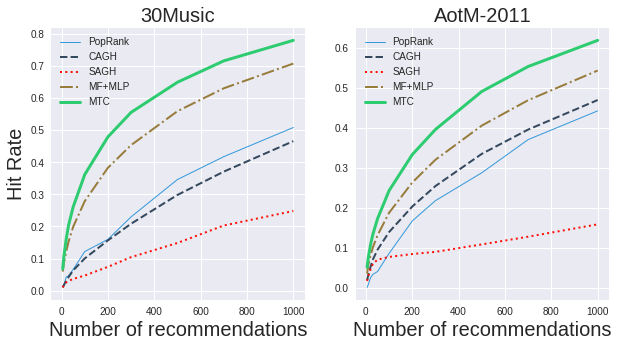

In [79]:
gen_curve('setting1', ('Hit-Rate', 'Hit Rate'), algos[:-1] + [('mf', 'MF+MLP'), ('mtc', 'MTC')], svgfile='hr1.svg')

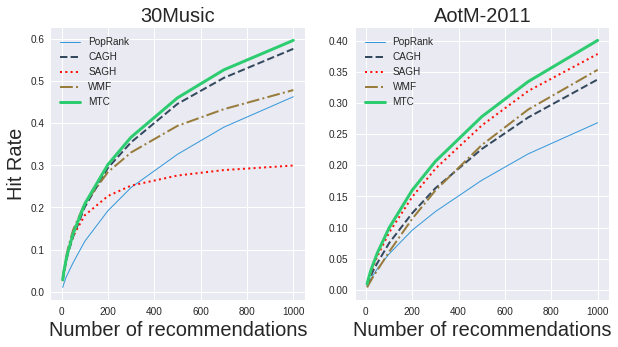

In [80]:
gen_curve('setting3', ('Hit-Rate', 'Hit Rate'), algos[:-1] + [('mf', 'WMF'), ('mtc', 'MTC')], svgfile='hr3.svg')

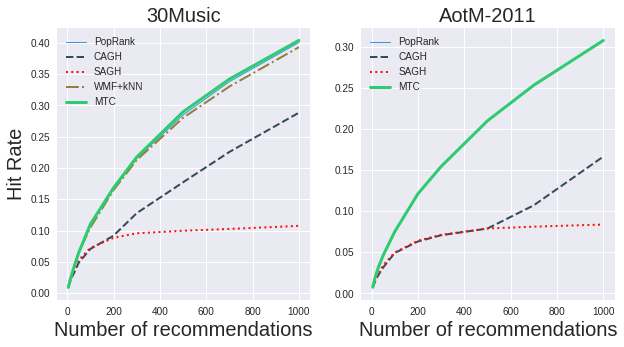

In [81]:
gen_curve('setting4', ('Hit-Rate', 'Hit Rate'), algos[:-1] + [('mf', 'WMF+kNN'), ('mtc', 'MTC')], svgfile='hr4.svg')

### Novelty

Moderate values are preferable

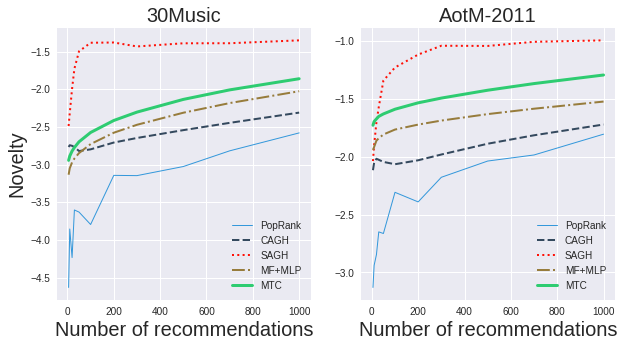

In [112]:
gen_curve('setting1', ('Novelty', 'Novelty'), algos[:-1] + [('mf', 'MF+MLP'), ('mtc', 'MTC')], svgfile='nov1.svg',
          legend_loc='lower right')

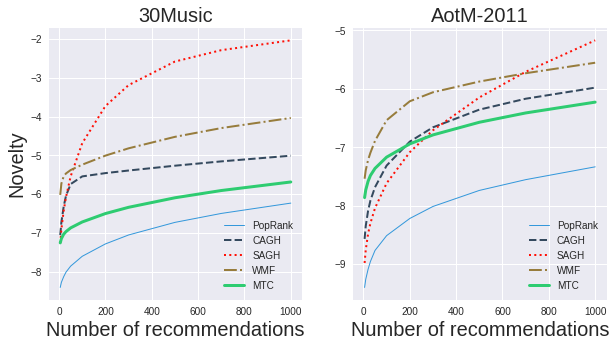

In [111]:
gen_curve('setting3', ('Novelty', 'Novelty'), algos[:-1] + [('mf', 'WMF'), ('mtc', 'MTC')], svgfile='nov3.svg',
          legend_loc='lower right')

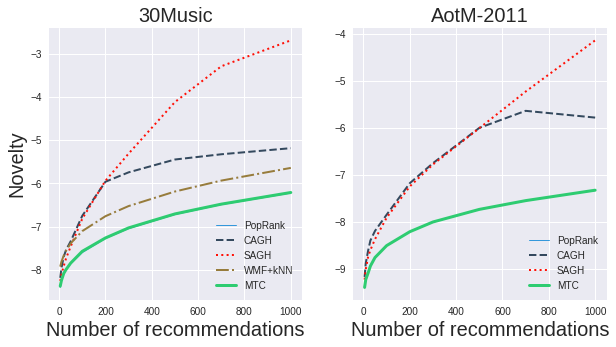

In [110]:
gen_curve('setting4', ('Novelty', 'Novelty'), algos[:-1] + [('mf', 'WMF+kNN'), ('mtc', 'MTC')], svgfile='nov4.svg',
          legend_loc='lower right')

### Artist diversity

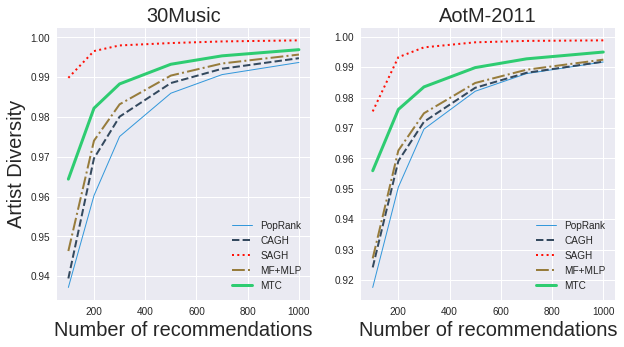

In [124]:
gen_curve('setting1', ('Artist-Diversity', 'Artist Diversity'), algos[:-1] + [('mf', 'MF+MLP'), ('mtc', 'MTC')], 
          svgfile='adiv1.svg', legend_loc='lower right', TOPs=TOPs[5:])

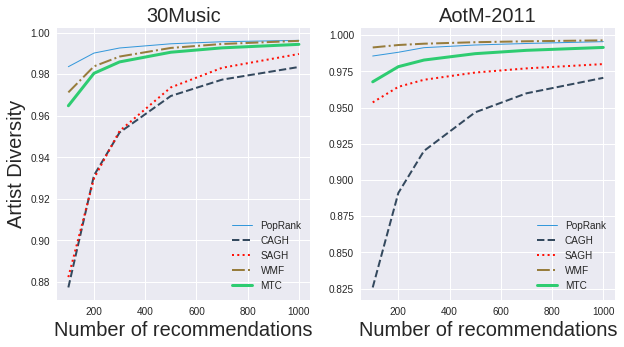

In [125]:
gen_curve('setting3', ('Artist-Diversity', 'Artist Diversity'), algos[:-1] + [('mf', 'WMF'), ('mtc', 'MTC')], 
          svgfile='adiv3.svg', legend_loc='lower right', TOPs=TOPs[5:])

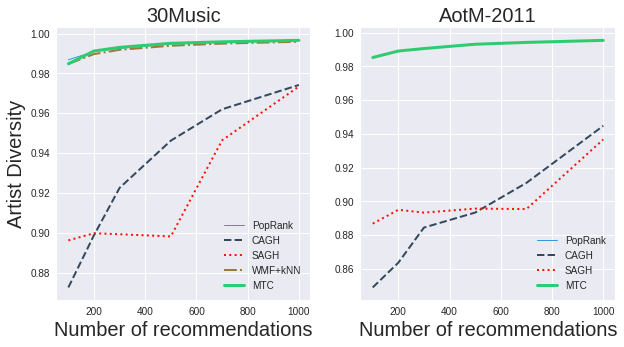

In [127]:
gen_curve('setting4', ('Artist-Diversity', 'Artist Diversity'), algos[:-1] + [('mf', 'WMF+kNN'), ('mtc', 'MTC')], 
          svgfile='nov4.svg', legend_loc='lower right', TOPs=TOPs[5:])

### Genre diversity

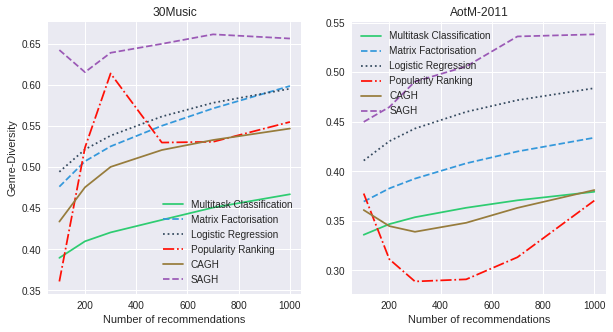

In [47]:
gen_curve('setting1', ('Genre-Diversity', 'Genre-Diversity'), algos, legend_loc='best', TOPs=TOPs[4:])

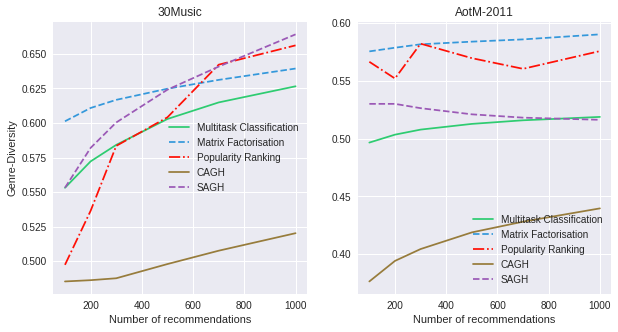

In [48]:
gen_curve('setting3', ('Genre-Diversity', 'Genre-Diversity'), algos, legend_loc='best', TOPs=TOPs[4:])

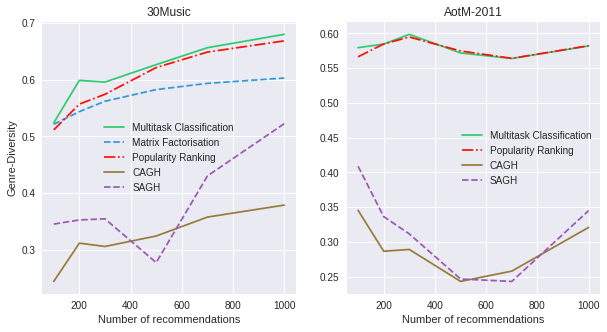

In [49]:
gen_curve('setting4', ('Genre-Diversity', 'Genre-Diversity'), algos, legend_loc='best', TOPs=TOPs[4:])